In [94]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness
from PIL import Image

In [95]:
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)

In [96]:
#load data
def load_data(folder_path):
    folder=os.listdir(folder_path)
    images=[]
    for filename in folder:
        if(filename not in ["000601_1.jpg"]):
            images.append(filename)
    images = sorted(images)[:6000]
    return np.array(images)

In [97]:
image_filenames=load_data("/kaggle/input/vr-project/MSFD/1/face_crop")

In [98]:
mask_filenames = load_data("/kaggle/input/vr-project/MSFD/1/face_crop_segmentation")

In [99]:
for i,(actual,mask) in enumerate(zip(image_filenames,mask_filenames)):
    if(actual != mask):
        print(actual,mask)
        break

In [100]:
def display_data(actual_img, mask_img, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = plt.imread(actual_img + image_path)
        mask = plt.imread(mask_img + mask_path)
        print(image_path, mask_path)
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    return

[4075, 2180, 2982, 5221, 1986]
003508_1.jpg 003508_1.jpg
001742_1.jpg 001742_1.jpg
002469_1.jpg 002469_1.jpg
004646_1.jpg 004646_1.jpg
001564_2.jpg 001564_2.jpg


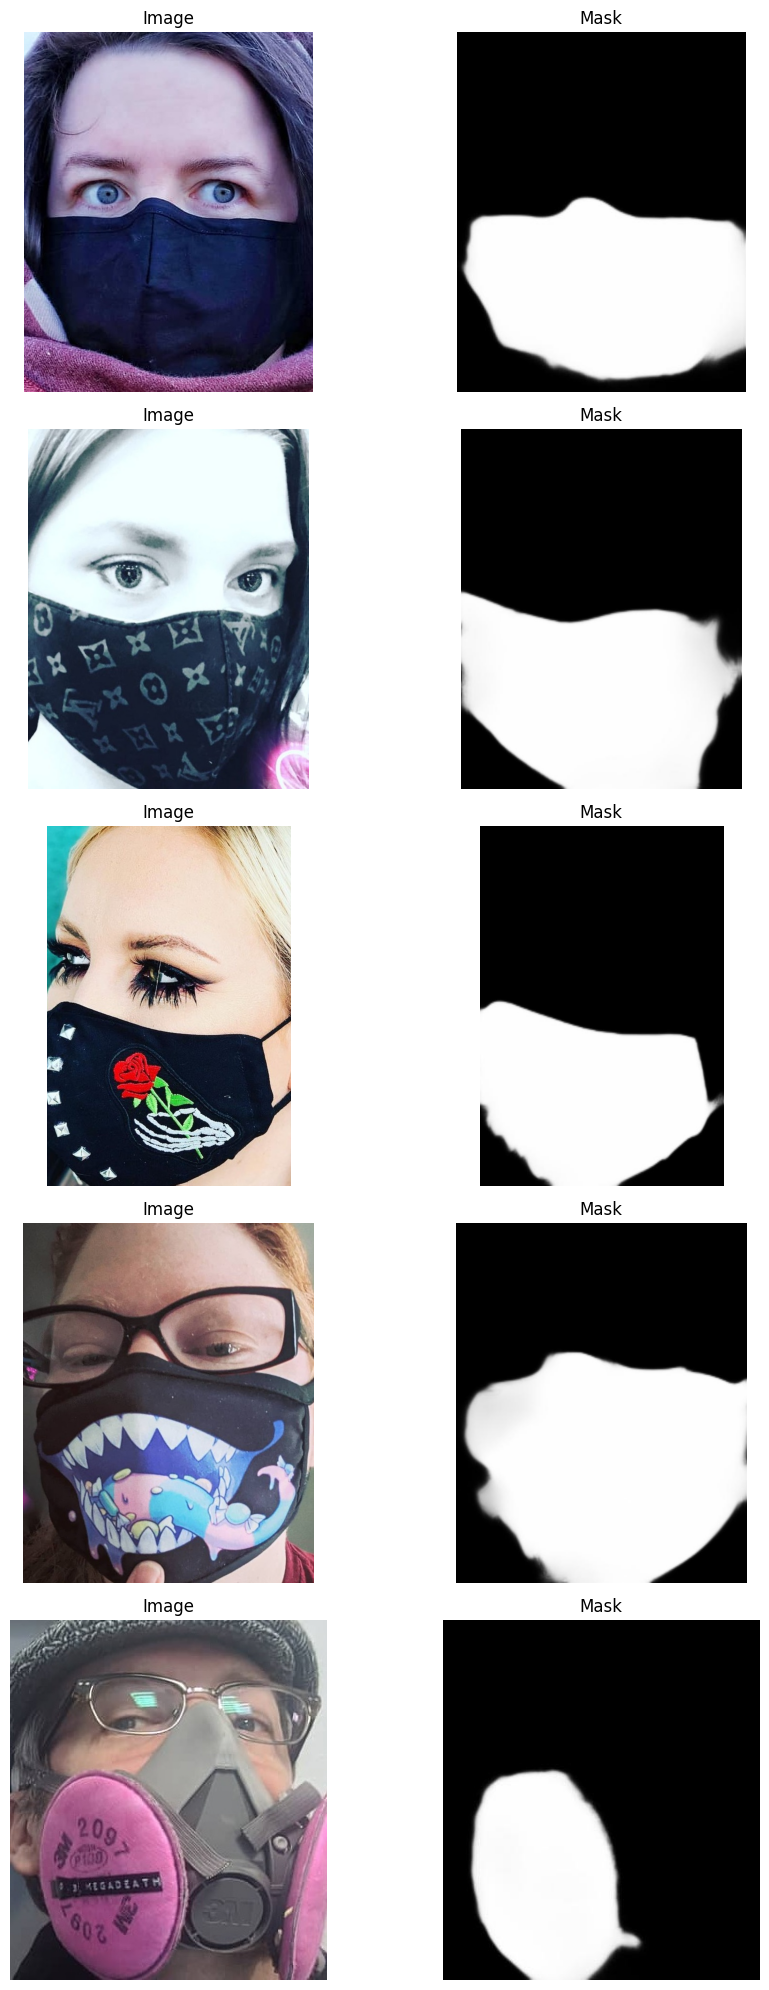

In [101]:
indices=random.sample(range(0,len(sat_image_filenames)),5)
print(indices)
display_data("/kaggle/input/vr-project/MSFD/1/face_crop/","/kaggle/input/vr-project/MSFD/1/face_crop_segmentation/",image_filenames[indices],mask_filenames[indices])

In [102]:
#preprocessing
def preprocess_data(actual_img, mask_img, image_names, mask_names, input_size, augmented=False):

    images = []
    masks = []
    for img_file, mask_file in zip(image_names, mask_names):
        img = load_img(actual_img + img_file, target_size=input_size, color_mode='rgb')
        mask = load_img(mask_img + mask_file, target_size=input_size, color_mode='grayscale')

        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        mask_array = img_to_array(mask, dtype=np.bool_)

        # Append images and masks to the lists
        images.append(img_array)
        masks.append(mask_array)

        if augmented:
            images.append(flip_left_right(img_array))
            masks.append(flip_left_right(mask_array))

            images.append(flip_up_down(img_array))
            masks.append(flip_up_down(mask_array))

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [103]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [104]:
images,masks=preprocess_data("/kaggle/input/vr-project/MSFD/1/face_crop/","/kaggle/input/vr-project/MSFD/1/face_crop_segmentation/",image_filenames,mask_filenames,INPUT_SIZE)

In [105]:
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (6000, 256, 256, 3)
Shape of mask data: (6000, 256, 256, 1)


In [106]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=110)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=110)

In [107]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/models/save_best.keras', verbose=1, save_best_only=True)

In [108]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=1/5, patience=3, verbose=1)

In [109]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred)

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose

def unet(input_shape, output_layer):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    #conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    #conv1 = tf.keras.layers.BatchNormalization()(conv1)
    #conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    #conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    #conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    #conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    #conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    #conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    #conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #conv4 = Dropout(0.2)(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    #conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    #conv5 = tf.keras.layers.BatchNormalization()(conv5)
    #conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    #conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    #conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    #conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    #conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    #conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    #conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    #conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    #conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

In [111]:
model = unet(INPUT_SHAPE, output_layer=1)


In [112]:
optimizer = Adam(learning_rate=2e-4)

# Compile the model with the optimizer instance
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_coefficient])

In [113]:
epochs = 30
history = model.fit(train_images, train_masks, batch_size=4, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint,lr_scheduler])

Epoch 1/30
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coefficient: 0.7198 - loss: 0.6673
Epoch 1: val_loss improved from inf to 0.28289, saving model to /kaggle/working/models/save_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - dice_coefficient: 0.7200 - loss: 0.6668 - val_dice_coefficient: 0.8948 - val_loss: 0.2829 - learning_rate: 2.0000e-04
Epoch 2/30
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - dice_coefficient: 0.8963 - loss: 0.2647
Epoch 2: val_loss improved from 0.28289 to 0.21946, saving model to /kaggle/working/models/save_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - dice_coefficient: 0.8963 - loss: 0.2647 - val_dice_coefficient: 0.9187 - val_loss: 0.2195 - learning_rate: 2.0000e-04
Epoch 3/30
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - dice_coefficient: 0.9147 - loss: 0.2197
Epoch 3: val_loss improved from 0.21946 to 0.21309, saving model to /kaggle/working/models/save_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - dice_coefficient: 0.9147 - 

In [114]:
from tensorflow.keras.models import load_model

# Load the best saved model after training
best_model = load_model('/kaggle/working/models/save_best.keras',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})


In [115]:
best_model.save('/kaggle/working/models/mask_model.h5')

In [116]:
eval = best_model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - dice_coefficient: 0.9497 - loss: 0.1577
Test accuracy: 0.95


In [117]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/mask_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient})

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


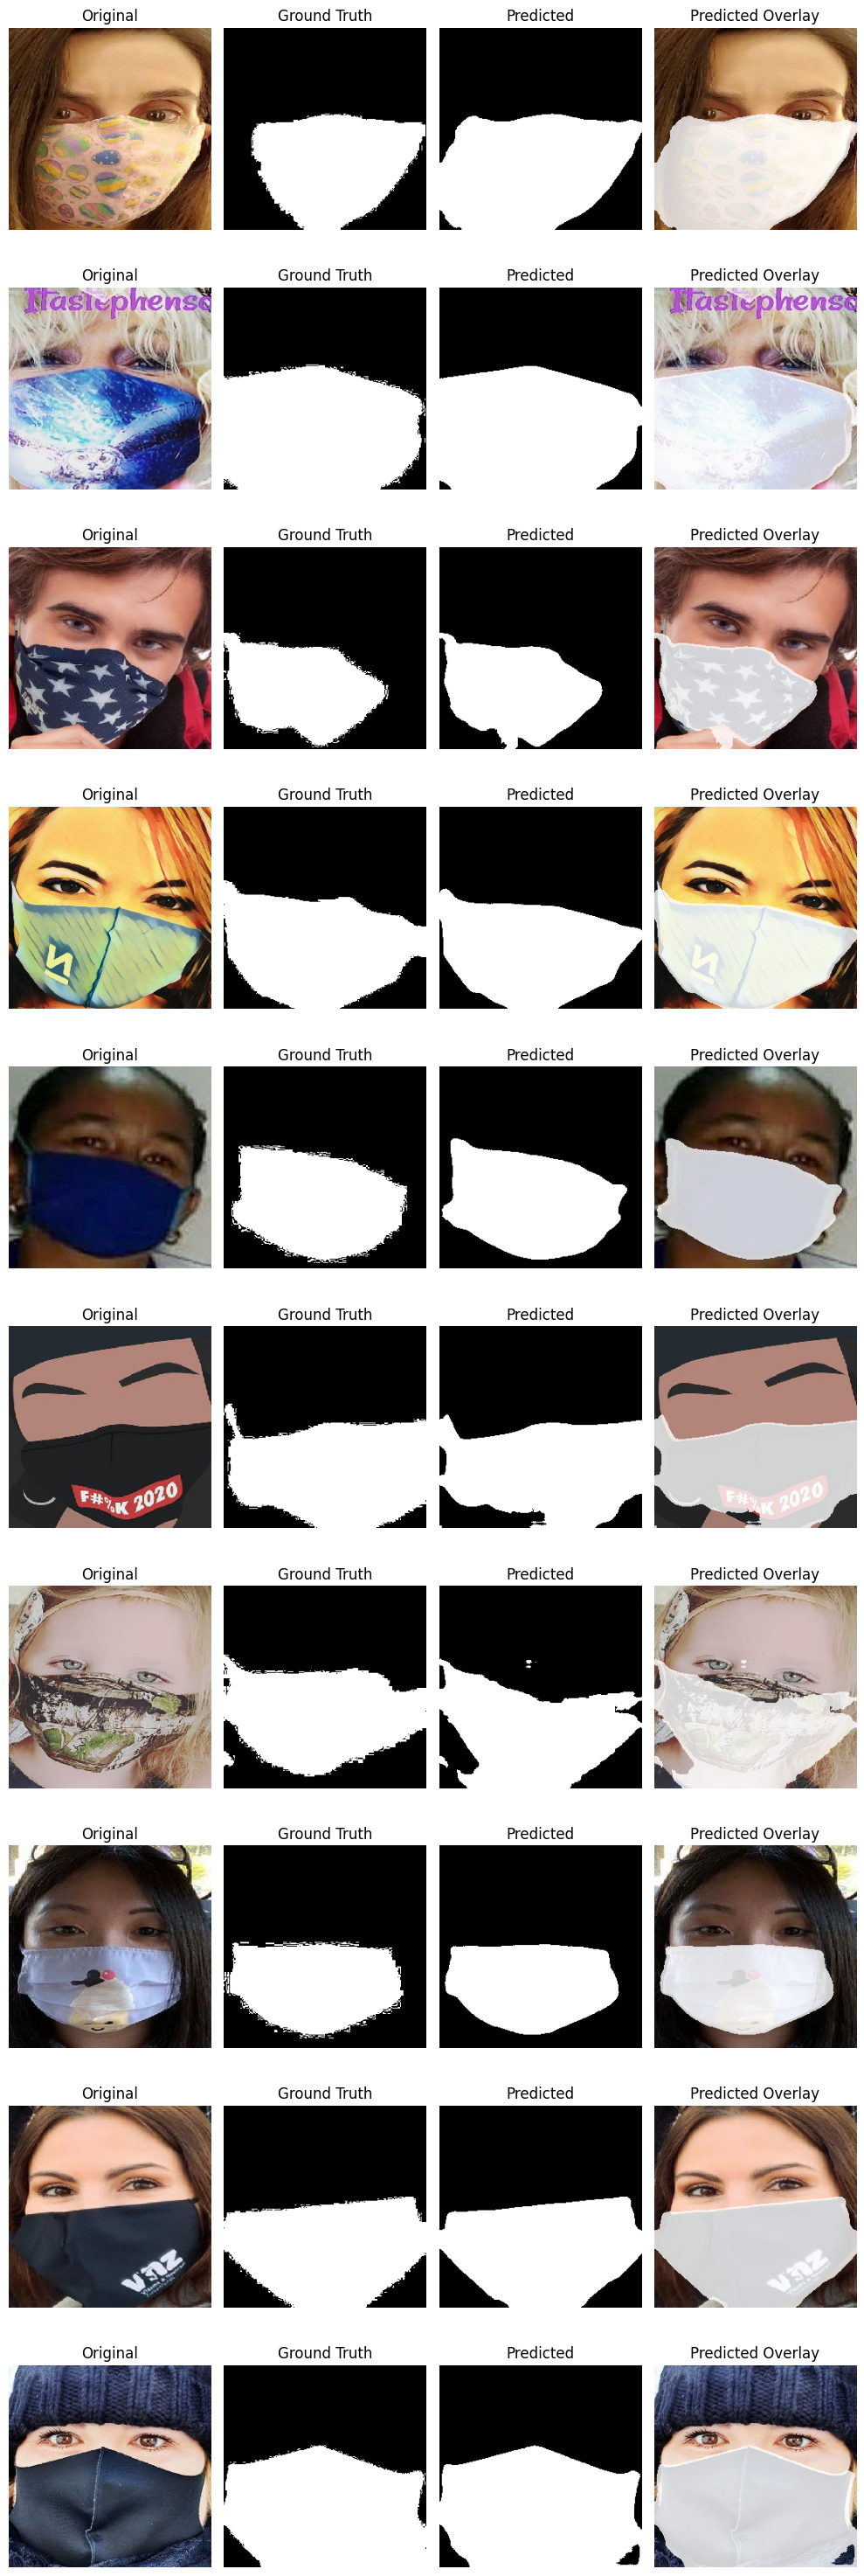

In [118]:
# display 10 random predictions
random.seed(50)
predictions = model.predict(test_images)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(10):

    image = (test_images[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()

In [119]:
predictions=model.predict(test_images)
predictions = (predictions > 0.5).astype(np.uint8)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [120]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score

def flatten_masks(masks):
    return masks.reshape(masks.shape[0], -1)  # Flatten each image in the batch

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)  # Add small epsilon to avoid division by zero

# Flatten the masks and predictions
flat_predictions = flatten_masks(predictions)
flat_test_masks = flatten_masks(test_masks)

total_accuracy = 0
total_precision = 0
total_recall = 0
total_iou = 0
total_dice = 0
num_samples = predictions.shape[0]

# Loop through each sample and compute the metrics
for i in range(num_samples):
    y_true = flat_test_masks[i]
    y_pred = flat_predictions[i]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    iou = jaccard_score(y_true, y_pred, zero_division=0)
    dice = dice_score(y_true, y_pred)
    
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_iou += iou
    total_dice += dice

# Compute average metrics
avg_accuracy = total_accuracy / num_samples
avg_precision = total_precision / num_samples
avg_recall = total_recall / num_samples
avg_iou = total_iou / num_samples
avg_dice = total_dice / num_samples

# Print the results
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average IoU: {avg_iou:.4f}')
print(f'Average Dice Score: {avg_dice:.4f}')

Average Accuracy: 0.9672
Average Precision: 0.9606
Average Recall: 0.9508
Average IoU: 0.9167
Average Dice Score: 0.9537
